In [2]:
#Packages required 

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler #for robust feature scaling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc
from scipy import stats # Hypthesis testing 
import seaborn as sns
# add in special sauce to use our python files containing useful functions
#import plots as pe
#import models as mods

In [5]:
import plots as pe
import models as mods

In [6]:
#Packages required 

# Read and characterise data
data_df = pd.read_csv("datasets/data.csv")


Number of Malignant tumours: 212
Number of Benign tumours   : 357
Sample size                    : 569
Number of independent variables: 30


/home/jovyan/work/plots.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtickmarks)
/home/jovyan/work/plots.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtickmarks)
/home/jovyan/work/plots.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtickmarks)
/home/jovyan/work/plots.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtickmarks)


The t-value: [-25.72159026]
The p-value: [2.8288477e-97]
Variable name: Area worst: t-value: [-25.72159026], p-value: [2.8288477e-97]
Variable name: Fractal dimension mean: t-value: [0.30571113], p-value: [0.7599368]
Variable name: Radius se: t-value: [-16.39635103], p-value: [9.73894866e-50]
Accuracy for the training sample: 0.99
[[69  3]
 [ 1 41]]
Accuracy on the test data:  0.96

Logistic regression model 
Classification report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        72
           1       0.93      0.98      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Accuracy score 0.9649

The AUC score for the logistic regression model is: 0.9947


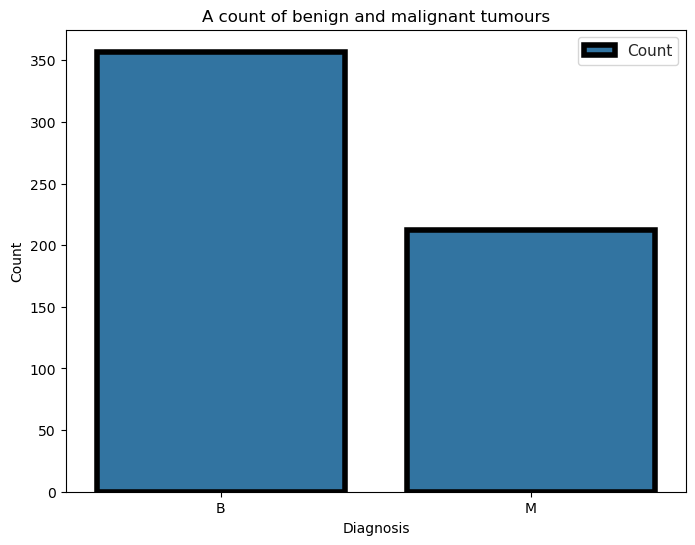

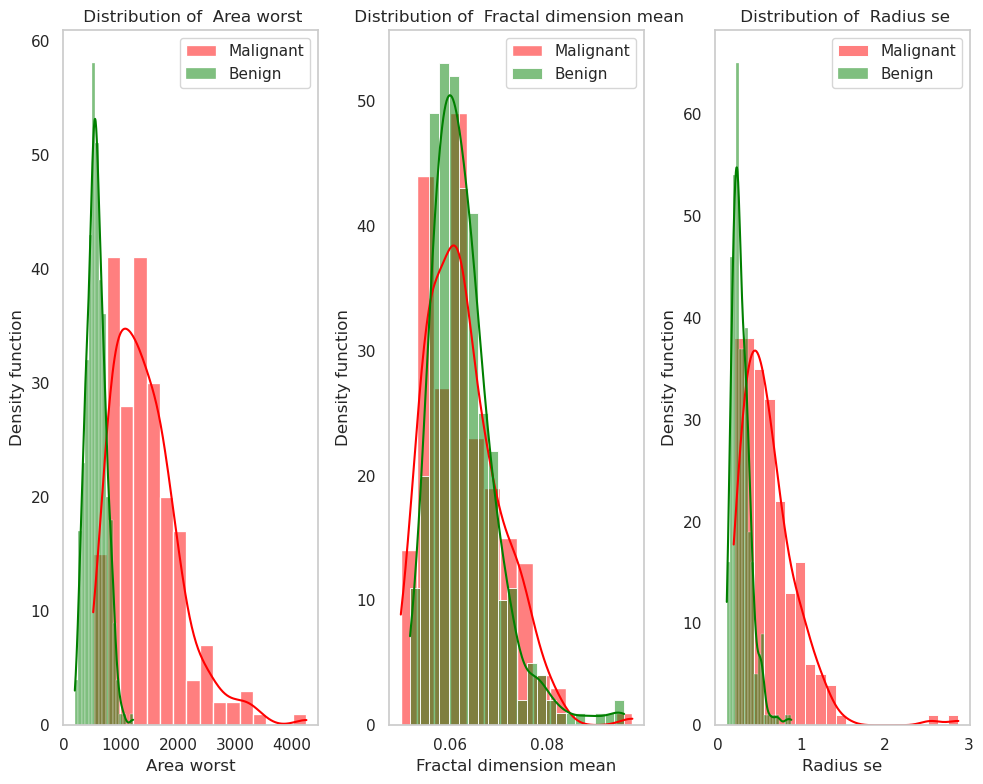

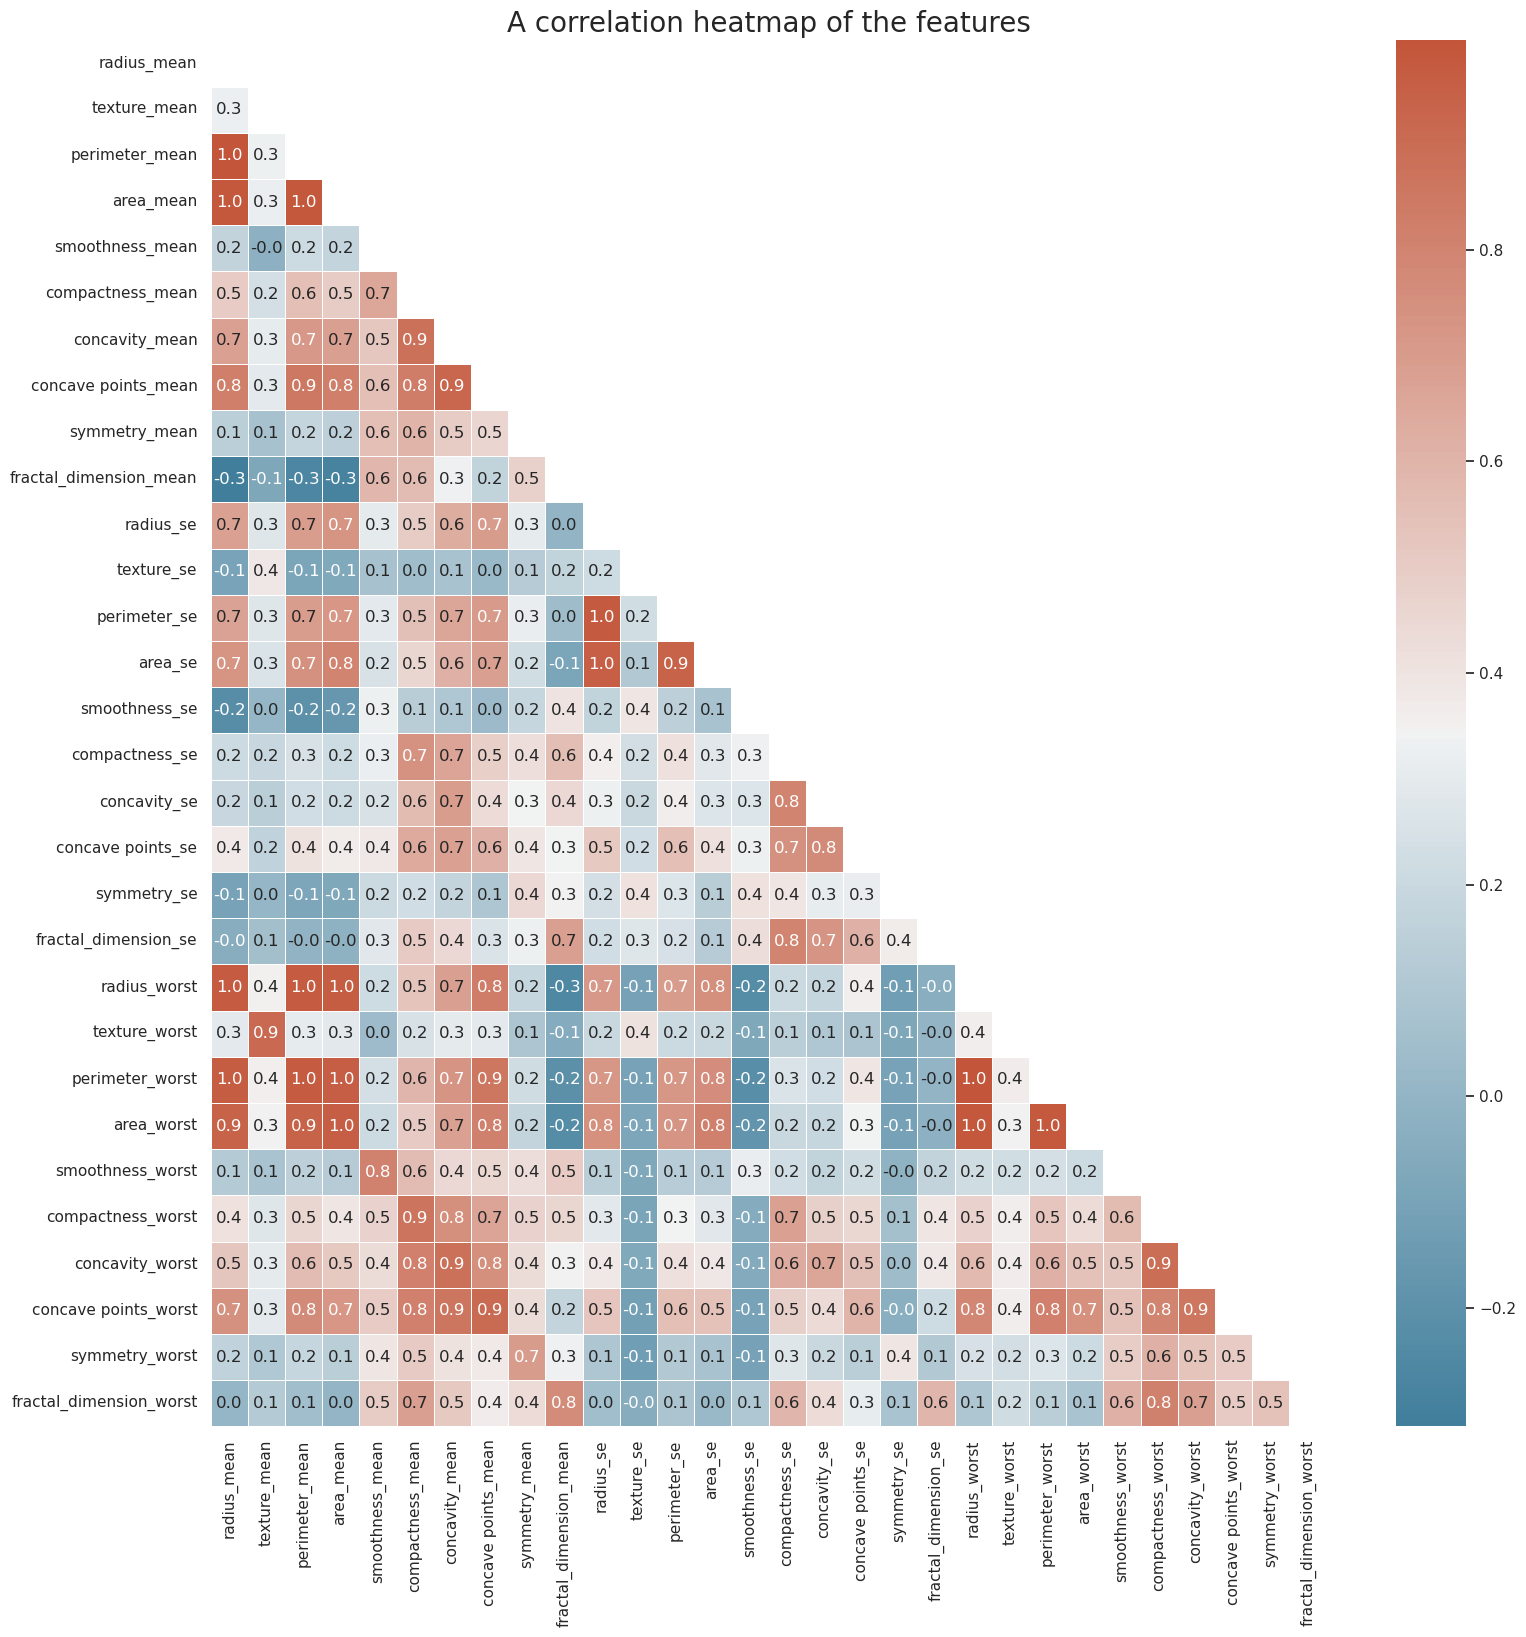

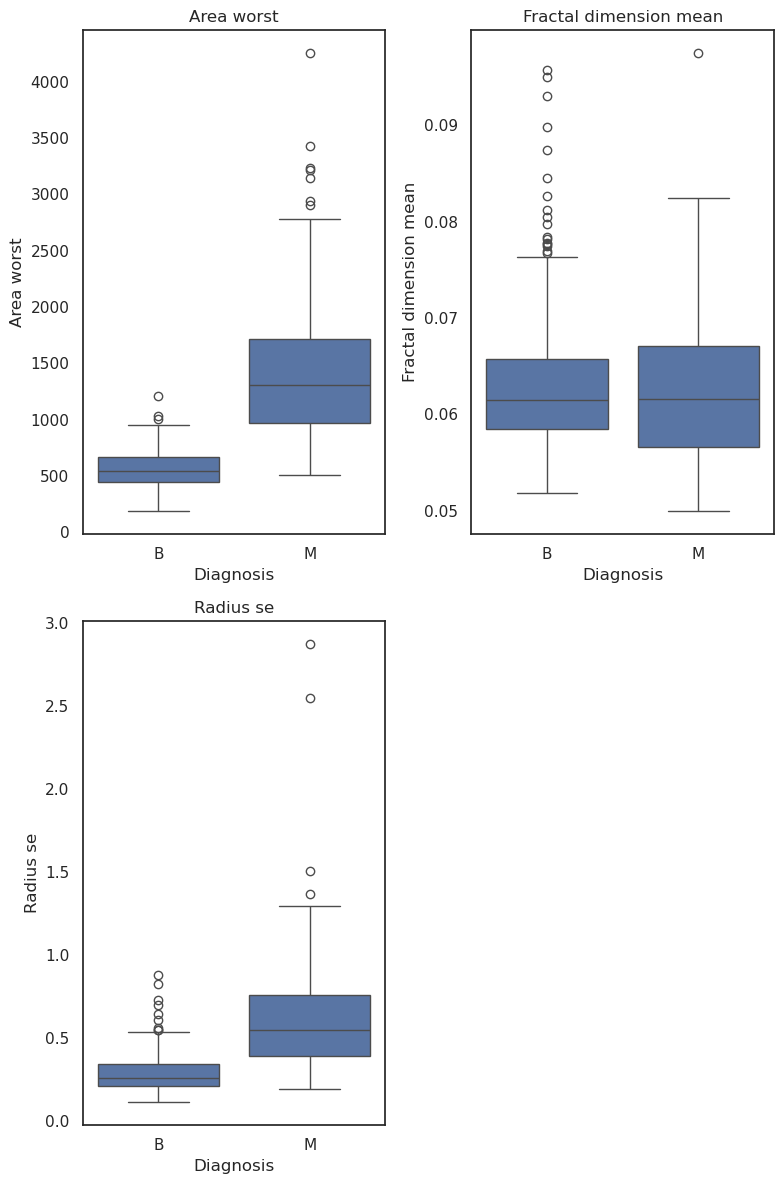

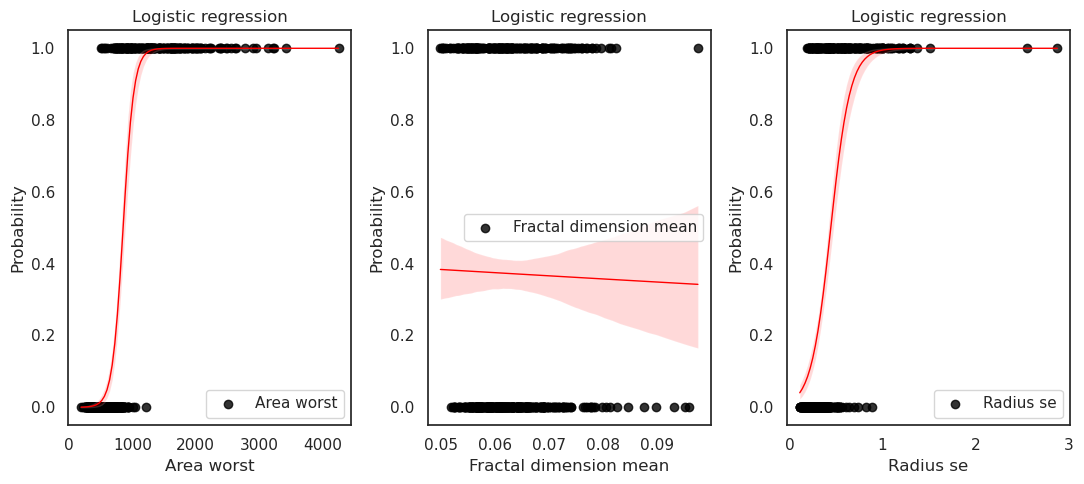

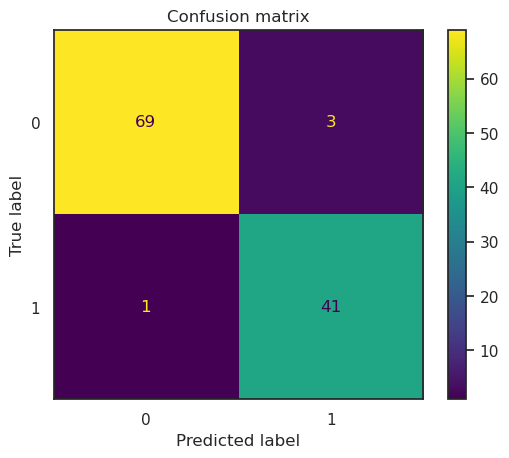

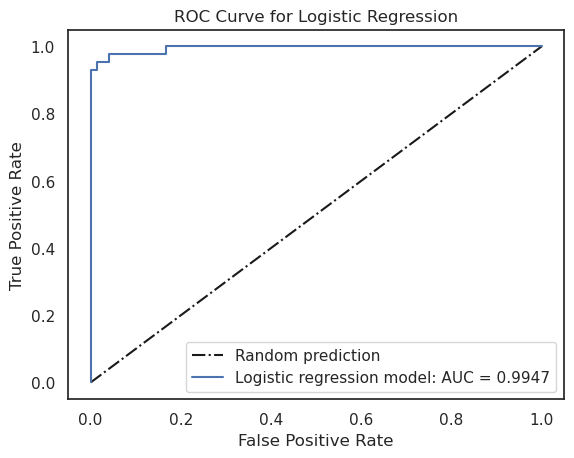

In [7]:
data_df.head().T
#data_df.info()
data_df.diagnosis = data_df.diagnosis.apply(lambda x: 1 if x == 'M' else 0)
#data_df.info()
data_df.shape
data_df.columns
data_df = data_df.dropna(axis = 1)

B, M = data_df.diagnosis.value_counts()
xtickmarks = ['B', 'M']

print(f'Number of Malignant tumours: {M}')
print(f'Number of Benign tumours   : {B}')

pe.createCountplot(data_df, xtickmarks)

variables_to_omit = ['id', 'diagnosis']
input_data = data_df.drop(variables_to_omit, axis = 1)
r, c = input_data.shape
print(f'Sample size                    : {r}')
print(f'Number of independent variables: {c}')

# Histograms
# 
Malignant = data_df[data_df['diagnosis'] == 1]
Benign = data_df[data_df['diagnosis'] == 0]
worst_mean_se = ['area_worst', 'fractal_dimension_mean', 'radius_se']

bins = 'fd'

pe.makeHistogram(worst_mean_se, Malignant,Benign,  bins)

# **Heatmaps** provide an informative way to depict two-dimensional data of the kind we have before us. A *heatmap* is an image in which the colour of each pixel is determined by the corresponding value in the array of data. 

pe.createHeatmap(input_data)

# More plots

# Create box and whiskers plot for texture mean by diagnosis of tumour
Diagnosis = 'diagnosis'

pe.makeBoxplot(worst_mean_se, data_df, Diagnosis, xtickmarks)

# Logistic regression plots

# Some more box and whiskers plots

pe.logistic_regression_plot(worst_mean_se, data_df, Diagnosis)

# Hypothesis testing using Student's t-test.

# Make a new dataframe with only the desired feature for t test  
hypothesis_test_data = pd.DataFrame(data = data_df[['area_worst', 'diagnosis']])
hypothesis_test_data = hypothesis_test_data.set_index(Diagnosis)
t, p = stats.ttest_ind(hypothesis_test_data.loc[0], hypothesis_test_data.loc[1])
print(f'The t-value: {t}')
print(f'The p-value: {p}')


class Hypothesis_T_Test(object):
    def __init__(self, feature, ind_variable = Diagnosis):
        self.feature = feature
        self.ind_variable = ind_variable
        
    def computeTandPValues(self):
        hypothesis_test_data = pd.DataFrame(data = data_df[[self.feature, self.ind_variable]])
        hypothesis_test_data = hypothesis_test_data.set_index(self.ind_variable)
        self.variable_name = lambda : data_df[self.feature].name.replace('_', ' ').capitalize()
        self.t_value, self.p_value = stats.ttest_ind(hypothesis_test_data.loc[0], hypothesis_test_data.loc[1])
        print(f'Variable name: {self.variable_name()}: t-value: {self.t_value}, p-value: {self.p_value}')
        
        return self.t_value, self.p_value

for feature in worst_mean_se:
    HTT = Hypothesis_T_Test(feature)
    HTT.computeTandPValues()


# Some correlation 

# Create a correlation matrix
corr_matrix = input_data.corr().abs()
# Select upper triangle of correlation matrix
upper_triangular = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
correlation_threshold = 0.95
features_to_omit = [column for column in upper_triangular.columns if any(upper_triangular[column] > correlation_threshold)]
# Remove features to omit 
correlation_data = input_data.drop(input_data[features_to_omit], axis = 1)
correlation_data.columns

# Machine learning

X = input_data
Y = data_df.diagnosis

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.20, 
                                                    stratify = Y, 
                                                    random_state = 1234)

# Robust feature scaling
rs_object = RobustScaler()
X_train = rs_object.fit_transform(X_train)
X_test = rs_object.transform(X_test)

#Obtain the training results
model = mods.createModel(X_train, y_train)

# Create Confusion matrix

cm = confusion_matrix(y_test, model.predict(X_test))
 
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
 
print(cm)
print(f'Accuracy on the test data: {(TP + TN) / (TP + TN + FN + FP): .2f}')
print()# Print a new line

# modify call to pass model.classes as parameter
pe.displayConfusionMatrix(cm, model)

# Classification report is used in machine learning to compute accuracy of a classification model from the values of the confusion matrix. In the classification report, precision is a measure of positive predictions.

print(f'Logistic regression model ')
#Check precision, recall, f1-score
print(f'Classification report')
print(classification_report(y_test, model.predict(X_test)))
#Another way to get the models accuracy on the test data
print(f'Accuracy score {accuracy_score(y_test, model.predict(X_test)):.4f}')
print() #Print a new line

# ROC Curve

# Compute predicted probabilities and keep results only for positive outcome 
y_pred_prob = model.predict_proba(X_test)[:,1]
# Generate ROC curve values and capture only fpr, and tpr, but not thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

print(f'The AUC score for the logistic regression model is: {auc(fpr, tpr):.4f}')

# modify called function to have params of true and false positive rate
pe.createROC(fpr,tpr)